<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Preprocess_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Preprocess_images**

In [17]:
from PIL import Image
import os
import time
from IPython.display import display
import numpy as np
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image, ImageOps
import sys
import cv2
from google.colab.patches import cv2_imshow


#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**ヒストグラム平坦化+シェーディング**

In [18]:
def Mirror_left_eye(pil_img, img_path):
    filename = os.path.splitext(img_path)[0]
    side = filename[-1]
    if side == "R":
        flipped_img = pil_img
    elif side == "L":
        img_mirror = ImageOps.mirror(pil_img)
        flipped_img = img_mirror
    return flipped_img

def crop2square(pil_img, x1, y1, x2, y2):
    cropped_img = pil_img.crop((x1,y1,x2,y2))
    return cropped_img


def crop_disc(pil_img):
    width, height = pil_img.size
    if width % 10 != 0:
        print("幅を10等分できません")
    if height % 10 != 0:
        print("高さを10等分できません")
    x_axis = int(width/10)
    y_axis = int(height/10)
    disc_img = pil_img.crop((5*x_axis, 3*y_axis, 9*x_axis, 7*y_axis))
    return disc_img

def crop_macula(pil_img):
    width, height = pil_img.size
    if width % 20 != 0:
        print("幅を5等分できません")
    if height % 20 != 0:
        print("高さを5等分できません")
    x_axis = int(width/20)
    y_axis = int(height/20)

    macula_img = pil_img.crop((4*x_axis, 7*y_axis, 10*x_axis, 13*y_axis))
    return macula_img


def pil2cv(image):
    ''' PIL型 -> OpenCV型 '''
    new_image = np.array(image, dtype=np.uint8)
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    return new_image

def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image


def shading(pil_img):
    #ここから
    src = pil2cv(pil_img)
    
    #RGBに分解
    src_r = src[:,:,2]
    src_g = src[:,:,1]
    src_b = src[:,:,0]
    shade_r = src_r - cv2.blur(src_r, (50,50)) +200
    shade_g = src_g - cv2.blur(src_g, (50,50)) +200
    shade_b = src_b - cv2.blur(src_b, (50,50)) +200
    shade = cv2.merge((shade_b, shade_g, shade_r))
    """
    src_yuv = cv2.cvtColor(src, cv2.COLOR_BGR2YUV)
    shade = src_yuv.copy()
    shade[:,:,0] = shade[:,:,0] - cv2.blur(shade[:,:,0], (50,50)) +200
    shade = cv2.cvtColor(shade, cv2.COLOR_YUV2BGR)
    """
    
    return shade

def equalization(cv2_img):
    #RGBに分解
    pic_r = cv2_img[:,:,2]
    pic_g = cv2_img[:,:,1]
    pic_b = cv2_img[:,:,0]

    # ヒストグラム平坦化
    dst_r = cv2.equalizeHist(pic_r) # グレイスケールしか使えない
    dst_g = cv2.equalizeHist(pic_g) # グレイスケールしか使えない
    dst_b = cv2.equalizeHist(pic_b) # グレイスケールしか使えない
    dst = cv2.merge((dst_b,dst_g,dst_r))
    return dst


**Shading (精度いまいち）**

In [ ]:
#画像処理の例
path =  "/content/drive/MyDrive/Deep_learning/FundusPhoto/img_train/img00699409_00_1R.jpg"

orig_img = Image.open(path)
flipped_img = Mirror_left_eye(orig_img, path)
shade_img = shading(flipped_img)
whole_crop = crop2square(cv2pil(shade_img), 590,240,1390,1040)
disc_crop = crop2square(cv2pil(shade_img), 1000,440,1400,840)
macula_crop = crop2square(cv2pil(shade_img), 570,470,910,810)

equalized_whole_crop = equalization(pil2cv(whole_crop))
equalized_disc_crop = equalization(pil2cv(disc_crop))
equalized_macula_crop = equalization(pil2cv(macula_crop))

infile = [0,0,0,0]
infile[0] = pil2cv(whole_crop)
infile[1] = pil2cv(equalized_whole_crop)
infile[2] = pil2cv(equalized_disc_crop)
infile[3] = pil2cv(equalized_macula_crop)

for i in infile:
    cv2_imshow(i)

In [20]:
orig_path = "/content/drive/MyDrive/Deep_learning/FundusPhoto/img_train"
dst_path_whole = "/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_shade_img"
dst_path_disc = "/content/drive/MyDrive/Deep_learning/FundusPhoto/disc_shade_img"
dst_path_macula = "/content/drive/MyDrive/Deep_learning/FundusPhoto/macula_shade_img"

os.chdir(orig_path)

def makefolder(dst_path):
    #フォルダを作成
    if os.path.exists(dst_path): #もしすでにフォルダがあれば削除
        shutil.rmtree(dst_path)
    os.mkdir(dst_path)  # 作成したいフォルダ名を作成

makefolder(dst_path_whole)
makefolder(dst_path_disc)
makefolder(dst_path_macula)

k=0
total = len(os.listdir(orig_path))
for i in os.listdir(orig_path):
    orig_img = Image.open(i)
    flipped_img = Mirror_left_eye(orig_img, i)
    shade_img = shading(flipped_img)
    whole_crop = crop2square(cv2pil(shade_img), 590,240,1390,1040)
    disc_crop = crop2square(cv2pil(shade_img), 1000,440,1400,840)
    macula_crop = crop2square(cv2pil(shade_img), 570,470,910,810)

    equalized_whole_crop = equalization(pil2cv(whole_crop))
    equalized_disc_crop = equalization(pil2cv(disc_crop))
    equalized_macula_crop = equalization(pil2cv(macula_crop))

    cv2.imwrite(os.path.join(dst_path_whole, os.path.splitext(i)[0])+".png", equalized_whole_crop)
    cv2.imwrite(os.path.join(dst_path_disc, os.path.splitext(i)[0])+".png", equalized_disc_crop)
    cv2.imwrite(os.path.join(dst_path_macula, os.path.splitext(i)[0])+".png", equalized_macula_crop)

    k+=1
    print(str(k)+"/"+str(total)+" files processed")



1/1414 files processed
2/1414 files processed
3/1414 files processed
4/1414 files processed
5/1414 files processed
6/1414 files processed


TypeError: ignored

**Split dataset for crossvaridation**

In [21]:
def get_path(orig_path, dst_path, split_num):
    #データの分割数を設定
    data_list = [0]
    k=0
    data_list = glob.glob(orig_path+'/*')
    split_length = int(len(data_list)/split_num)
    return data_list, split_length

def makefolder(orig_path, dst_path):
    #フォルダを作成
    if os.path.exists(dst_path): #もしすでにフォルダがあれば削除
        shutil.rmtree(dst_path)
    os.mkdir(dst_path)  # 作成したいフォルダ名を作成
    for i in range(split_num):
        os.mkdir(dst_path+'/'+str(i))
        os.mkdir(dst_path+'/'+str(i)+'/train')
        os.mkdir(dst_path+'/'+str(i)+'/val')

def split_data_list(data_list, split_num):
    split_data, dst_data, dst_train, dst_val, dst_test = [0]*split_num, [0]*split_num, [0]*split_num, [0]*split_num, [0]*split_num

    #データの分割
    split_data = list(np.array_split(data_list, split_num))

    #データセット全体と分割したデータの差分を取り、dst_dataに格納

    dst_data = [0] * split_num
    for i in range(split_num):
        dst_data[i] = [x for x in data_list if x not in split_data[i]]

    #トレーニングセット、バリデーションセット、テストセットのリスト作成
    for i in range(split_num):
        dst_train[i] = dst_data[i]
        dst_val[i] = split_data[i]  #テストセット
    
    return dst_train, dst_val

def copy_to_folders(split_num,  dst_train, dst_val, dst_path):
    k=0
    for i in range(split_num):
        dst_path_train = dst_path +'/'+str(i)+'/train'
        dst_path_val = dst_path +'/'+str(i)+'/val'
        for p in dst_train[k]:  # 選択したファイルを目的フォルダにコピー
            shutil.copy(p, dst_path_train)
            #print(p)
            print(dst_path_train)

        for p in dst_val[k]:  # 選択したファイルを目的フォルダにコピー
            shutil.copy(p, dst_path_val)
            #print(p)    
            print(dst_path_val)

        k+=1

In [ ]:
orig_path = ["/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_shade_img", "/content/drive/MyDrive/Deep_learning/FundusPhoto/disc_shade_img", "/content/drive/MyDrive/Deep_learning/FundusPhoto/macula_shade_img"]
dst_path = ["/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_shade_img_trainval", "/content/drive/MyDrive/Deep_learning/FundusPhoto/disc_shade_img_trainval", "/content/drive/MyDrive/Deep_learning/FundusPhoto/macula_shade_img_trainval"]  # フォルダ名
split_num = 5  #データをいくつに分割するかを記載

for orig_path, dst_path in zip(orig_path, dst_path):
    data_list, split_length = get_path(orig_path, dst_path, split_num)
    makefolder(orig_path, dst_path)

    dst_train, dst_val = split_data_list(data_list, split_num)
    copy_to_folders(split_num, dst_train, dst_val, dst_path)

**CRAHE & SHADE**

Blur


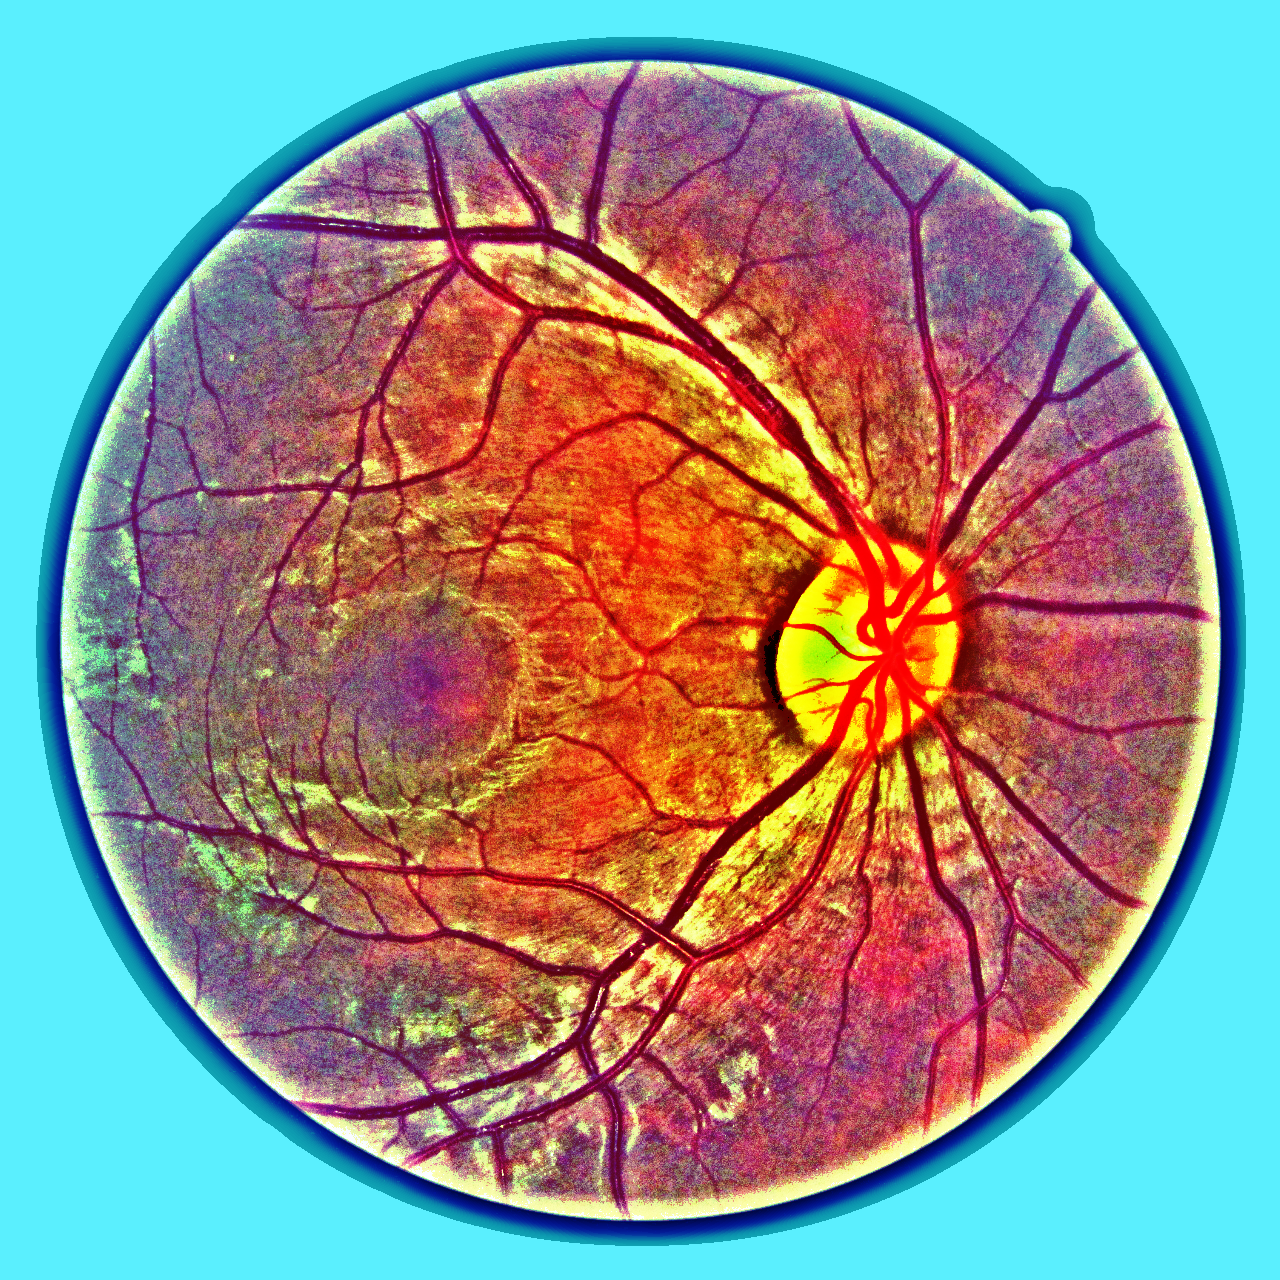

True

In [23]:
"""
def show_histogram(img):
    hist = cv2.calcHist([img],[2],None,[256],[0,256]) 
    plt.plot(hist,color = "b")
    plt.show()
"""

path =  "/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_2_img/img00699409_00_1R.png"

# 適用的ヒストグラム平坦化　CLAHEを定義
clahe1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
clahe4 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
clahe8 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe16 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
clahe32 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))


#ここから
src = cv2.imread(path)
src_yuv = cv2.cvtColor(src, cv2.COLOR_BGR2YUV)

#RGBに分解
src_r = src[:,:,2]
src_g = src[:,:,1]
src_b = src[:,:,0]

# ヒストグラム平坦化
dst_r = cv2.equalizeHist(src_r) # グレイスケールしか使えない
dst_g = cv2.equalizeHist(src_g) # グレイスケールしか使えない
dst_b = cv2.equalizeHist(src_b) # グレイスケールしか使えない
dst = cv2.merge((dst_b,dst_g,dst_r))

# 適用的ヒストグラム平坦化(4x4)
cl0_r = clahe4.apply(src_r)
cl0_g = clahe4.apply(src_g)
cl0_b = clahe4.apply(src_b)
cl0 = cv2.merge((cl0_b,cl0_g,cl0_r))

# 適用的ヒストグラム平坦化(8x8)
cl1_r = clahe8.apply(src_r)
cl1_g = clahe8.apply(src_g)
cl1_b = clahe8.apply(src_b)
cl1 = cv2.merge((cl1_b,cl1_g,cl1_r))

# 適用的ヒストグラム平坦化(16x16)
cl2_r = clahe16.apply(src_r)
cl2_g = clahe16.apply(src_g)
cl2_b = clahe16.apply(src_b)
cl2 = cv2.merge((cl2_b,cl2_g,cl2_r))

# 適用的ヒストグラム平坦化(32x32)
cl3_r = clahe32.apply(src_r)
cl3_g = clahe32.apply(src_g)
cl3_b = clahe32.apply(src_b)
cl3 = cv2.merge((cl3_b,cl3_g,cl3_r))

# ３色同時に調整（4x4)
cl0_yuv = src_yuv.copy()
cl0_yuv[:,:,0] = clahe4.apply(cl0_yuv[:,:,0])
cl0_yuv = cv2.cvtColor(cl0_yuv, cv2.COLOR_YUV2BGR)

# ３色同時に調整（8x8)
cl1_yuv = src_yuv.copy()
cl1_yuv[:,:,0] = clahe8.apply(cl1_yuv[:,:,0])
cl1_yuv = cv2.cvtColor(cl1_yuv, cv2.COLOR_YUV2BGR)

# ３色同時に調整（16x16)
cl2_yuv = src_yuv.copy()
cl2_yuv[:,:,0] = clahe16.apply(cl2_yuv[:,:,0])
cl2_yuv = cv2.cvtColor(cl2_yuv, cv2.COLOR_YUV2BGR)

# ３色同時に調整（32x32)
cl3_yuv = src_yuv.copy()
cl3_yuv[:,:,0] = clahe32.apply(cl3_yuv[:,:,0])
cl3_yuv = cv2.cvtColor(cl3_yuv, cv2.COLOR_YUV2BGR)

#Shading

blur_r = src_r - cv2.blur(src_r, (50,50))
blur_g = src_g - cv2.blur(src_g, (50,50))
blur_b = src_b - cv2.blur(src_b, (50,50))
blur = cv2.merge((blur_b, blur_g, blur_r))

src_yuv_mean = src_yuv.mean()
blur_yuv = src_yuv.copy()
blur_yuv[:,:,0] = blur_yuv[:,:,0] - cv2.blur(blur_yuv[:,:,0], (50,50)) +src_yuv_mean
blur_yuv = cv2.cvtColor(blur_yuv, cv2.COLOR_YUV2BGR)
blur_yuv = equalization(blur_yuv)



# 画像表示
"""
print("orig")
cv2_imshow(src)
print("equalized")
cv2_imshow(dst)
print("clahe4")
cv2_imshow(cl0)
print("clahe8")
cv2_imshow(cl1)
print("clahe16")
cv2_imshow(cl2)
print("clahe32")
cv2_imshow(cl3)
print("clahe4_yuv")
cv2_imshow(cl0_yuv)
print("clahe8_yuv")
cv2_imshow(cl1_yuv)
print("clahe16_yuv")
cv2_imshow(cl2_yuv)
print("clahe32_yuv")
cv2_imshow(cl3_yuv)
"""
print("Blur")
cv2_imshow(blur_yuv)

cv2.imwrite("/content/cl3.yuv.png", blur)




In [ ]:
# ヒストグラム平坦化でコントラスト強調                                                                                                      
def eqh(img):
    # 各色で平坦化                                                                                                                          
    b1,g1,r1 = cv2.split(img)
    b2 = cv2.equalizeHist(b1)
    g2 = cv2.equalizeHist(g1)
    r2 = cv2.equalizeHist(r1)
    eqh_rgb = cv2.merge((b2,g2,r2))

    # HSVのvだけ編集                                                                                                                        
    h1,s1,v1 = cv2.split(cv2.cvtColor(img,cv2.COLOR_BGR2HSV))  # 色空間をBGRからHSVに変換                                                   
    v2 = cv2.equalizeHist(v1)
    eqh_hsv = cv2.cvtColor(cv2.merge((h1,s1,v2)), cv2.COLOR_HSV2BGR)

    return eqh_rgb, eqh_hsv

# 部分的にヒストグラム平坦化でコントラスト強調                                                                                              
def clc(img,cl,gsize):
    b1,g1,r1 = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=(gsize,gsize))
    b2 = clahe.apply(b1)
    g2 = clahe.apply(g1)
    r2 = clahe.apply(r1)
    return cv2.merge((b2,g2,r2))

# 値を0-255にclipして、typeをuint8にする                                                                                                    
def ct(img):
    return np.clip(img,0,255).astype(np.uint8)

file_name = "/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_2_img/img00085024_00_1R.png"
img = cv2.imread(file_name)

# コントラスト強調画像を作成                                                                                                                
eqh_rgb, eqh_hsv = eqh(img)
clc_img = clc(img,2.,4)

# 全部混ぜる                                                                                                                                
ave_img = ct((np.float32(img) \
            + np.float32(eqh_rgb) \
            + np.float32(eqh_hsv) \
            + np.float32(clc_img))/4.)

cv2_imshow(ave_img)

In [ ]:
#画像処理の例
path =  "/content/drive/MyDrive/Deep_learning/FundusPhoto/img_train/img00699409_00_1R.jpg"

clahe16 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))

#ここから
src = cv2.imread(path)
src_yuv = cv2.cvtColor(src, cv2.COLOR_BGR2YUV)

# ３色同時に調整（16x16)
cl2_yuv = src_yuv.copy()
cl2_yuv[:,:,0] = clahe16.apply(cl2_yuv[:,:,0])
cl2_yuv = cv2.cvtColor(cl2_yuv, cv2.COLOR_YUV2BGR)

cv2_imshow(cl2_yuv)

**ちょうどいい感じのイメージ合成**
https://kp-ft.com/717

In [ ]:
#まとめて処理
orig_path = ["/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_2_img", "/content/drive/MyDrive/Deep_learning/FundusPhoto/disc_2_img", "/content/drive/MyDrive/Deep_learning/FundusPhoto/macula_2_img", "/content/drive/MyDrive/Deep_learning/FundusPhoto/vascular_2_img"]
dst_path = ["/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_CLAHE_img", "/content/drive/MyDrive/Deep_learning/FundusPhoto/disc_CLAHE_img", "/content/drive/MyDrive/Deep_learning/FundusPhoto/macula_CLAHE_img", "/content/drive/MyDrive/Deep_learning/FundusPhoto/vascular_CLAHE_img"]

def makefolder(dst_path):
    #フォルダを作成
    if os.path.exists(dst_path): #もしすでにフォルダがあれば削除
        shutil.rmtree(dst_path)
    os.mkdir(dst_path)  # 作成したいフォルダ名を作成


start_time = time.time()

for orig_path, dst_path in zip(orig_path, dst_path):
    makefolder(dst_path)
    os.chdir(orig_path)

    k=0
    total = len(os.listdir(orig_path))

    print(orig_path+" start!")
    for i in os.listdir(orig_path):
        #ここから
        src = cv2.imread(i)
        src_yuv = cv2.cvtColor(src, cv2.COLOR_BGR2YUV)

        # ３色同時に調整（16x16)
        cl2_yuv = src_yuv.copy()
        cl2_yuv[:,:,0] = clahe16.apply(cl2_yuv[:,:,0])
        cl2_yuv = cv2.cvtColor(cl2_yuv, cv2.COLOR_YUV2BGR)

        cv2.imwrite(os.path.join(dst_path, os.path.splitext(i)[0])+".png", cl2_yuv)

        k+=1
        print(str(k)+"/"+str(total)+" files processed")

    # calculate elapsed time
    elapsed_time = int(time.time() - start_time)

    # convert second to hour, minute and seconds
    elapsed_hour = elapsed_time // 3600
    elapsed_minute = (elapsed_time % 3600) // 60
    elapsed_second = (elapsed_time % 3600 % 60)

    # print as 00:00:00
    print(str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2))

#輝度の3次元グラフ

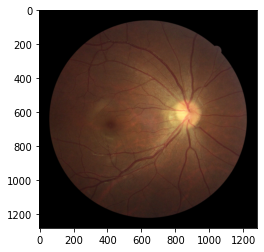

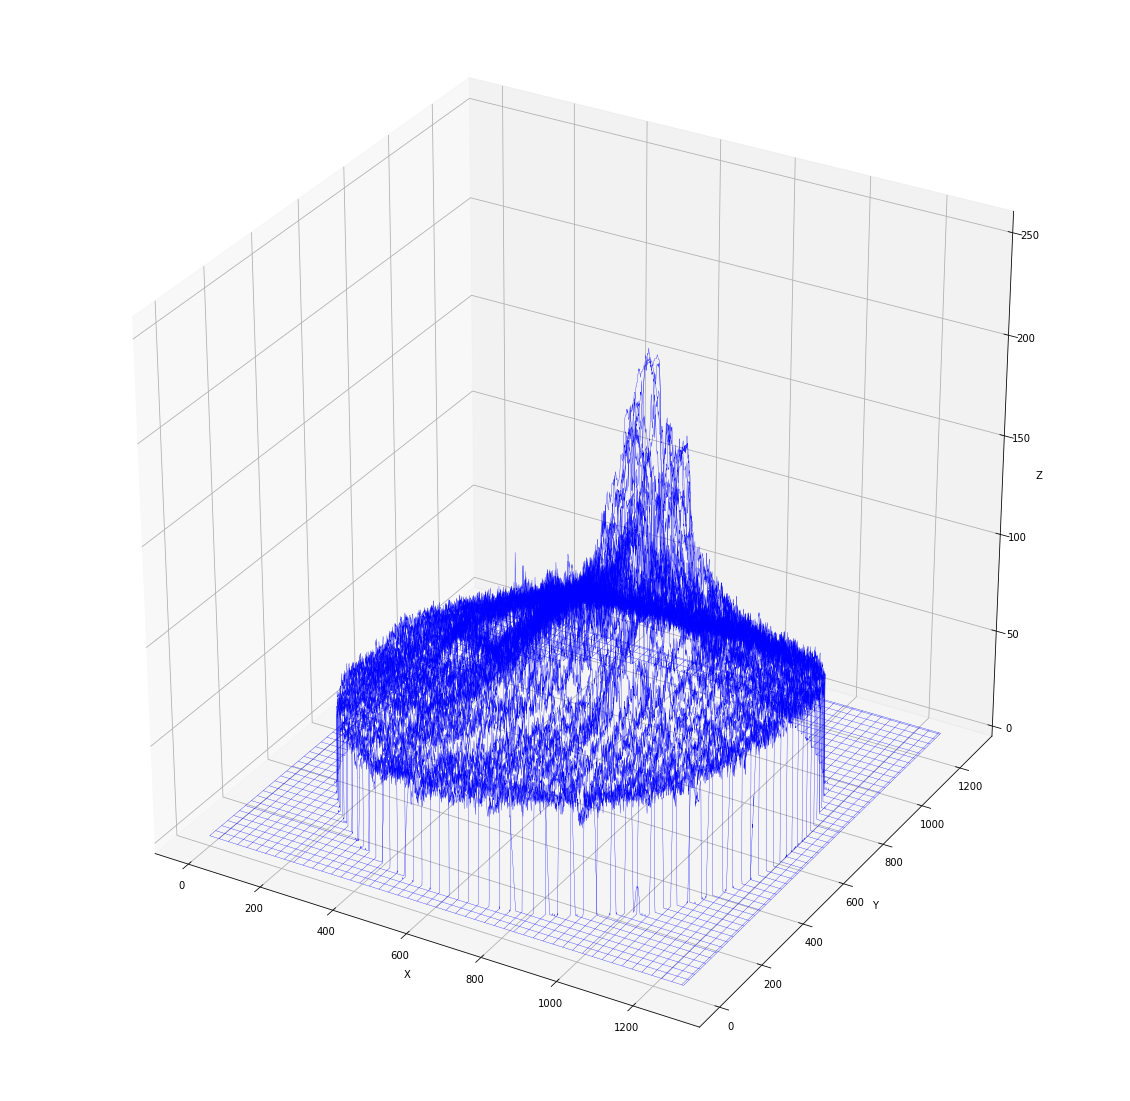

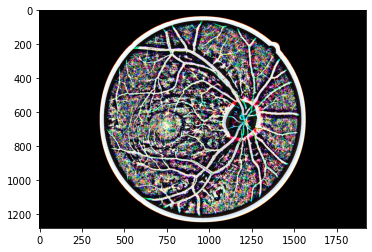

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


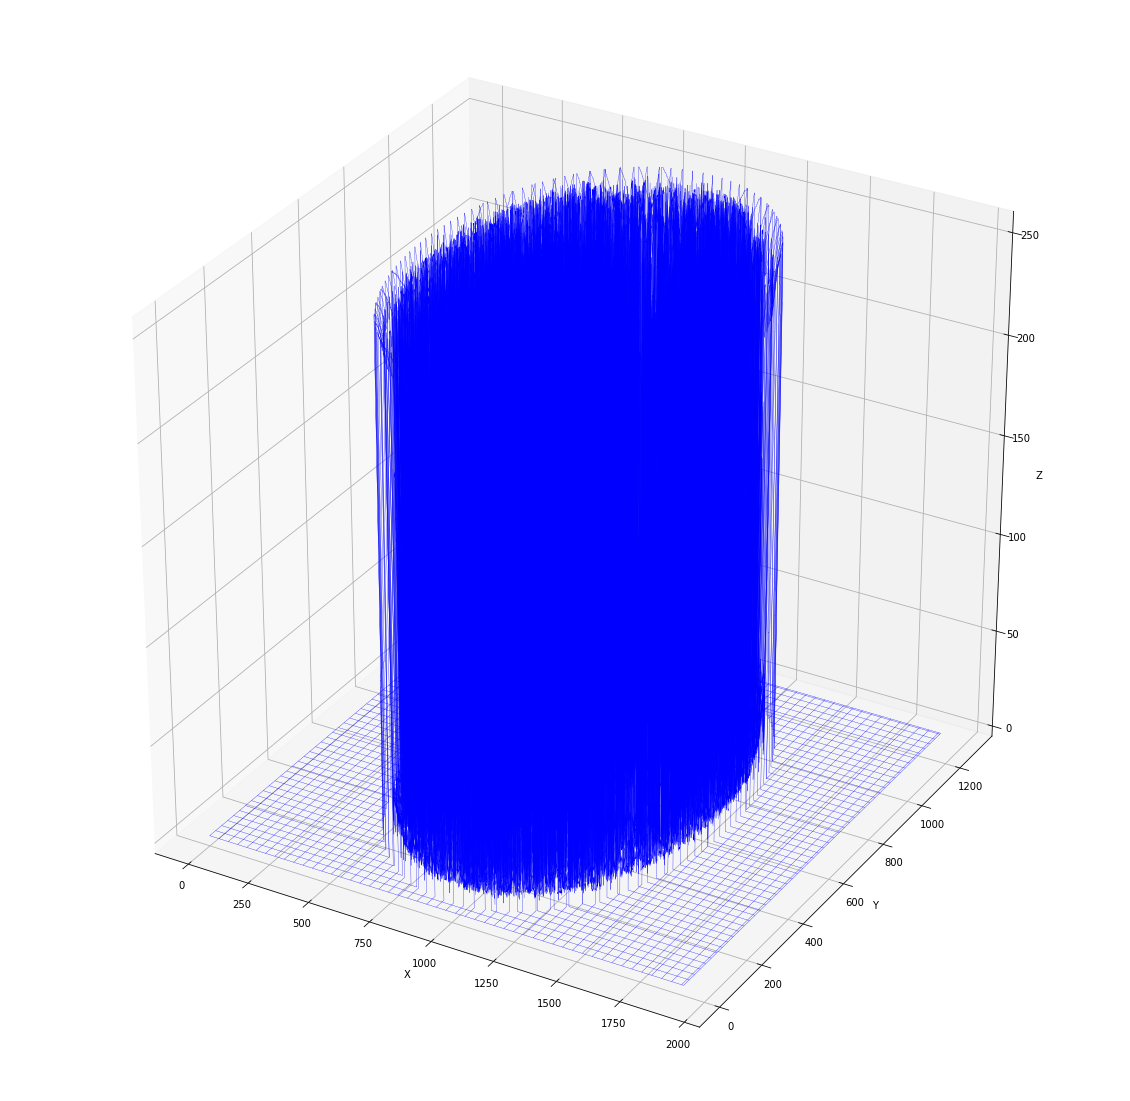

In [8]:
#輝度の3次元グラフを描く
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image


%matplotlib inline
path_dst = "/content/cl3.yuv.png"
path_orig =  "/content/drive/MyDrive/Deep_learning/FundusPhoto/cropped_2_img/img00265140_00_1R.png"
#画像の読み込み

def surface_plot(path): 
    src = Image.open(path)
    plt.imshow(src)
    plt.show()

    src_gray = src.convert("L").copy()  # グレースケール変換
    src_gray= np.asarray(src_gray)

    #3D Figure作成
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')


    x = np.arange(0, src.size[0], 1)
    y = np.arange(0, src.size[1], 1)

    x, y = np.meshgrid(x, y)
    z = np.asarray(src_gray)

    ax.set_zlim(0.0,255)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.plot_wireframe(x, y, z, color='blue',linewidth=0.3) # ワイヤーフレームのプロット。linewidthは曲面のメッシュの線の太さ，をそれぞれ表す。
    
    plt.show() # 絵の出力。


surface_plot(path_orig)
surface_plot(path_dst)




In [ ]:
#マスキング領域を指定
x=640 #pixel
y=640 #pixel
r=490 #pixel
#画像の読み込み
pic=cv2.imread(path_dst,cv2.IMREAD_COLOR)
h,w=pic.shape[:2]
#マスキング
mask=np.zeros((h,w),dtype=np.uint8)
cv2.circle(mask,center=(x,y),radius=r,color=255,thickness=-1)
pic[mask==0] = [0, 0, 0]
#画像出力
#cv2.imwrite('circle.jpg',np.array(pic))

#RGBに分解
pic_r = pic[:,:,2]
pic_g = pic[:,:,1]
pic_b = pic[:,:,0]

# ヒストグラム平坦化
dst_r = cv2.equalizeHist(pic_r) # グレイスケールしか使えない
dst_g = cv2.equalizeHist(pic_g) # グレイスケールしか使えない
dst_b = cv2.equalizeHist(pic_b) # グレイスケールしか使えない
dst = cv2.merge((dst_b,dst_g,dst_r))

cv2_imshow(dst)

#**224pxに縮小して保存（Image.BILINEAR）**

In [ ]:
path = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
ext = 'png'  #png or jpg

os.chdir(path)


#元画像フォルダ
in_path = ['cropped_2_img', 'disc_2_img', 'macula_2_img', 'vascular_2_img']

#保存先フォルダ
out_path = ['cropped_224_img', 'disc_224_img', 'macula_224_img', 'vascular_224_img']


In [ ]:
start_time = time.time()
process = [1]

for i in process:
    #保存先フォルダの作成
    if os.path.exists(out_path[i]):
        shutil.rmtree(out_path[i])
    os.makedirs(out_path[i])

    k=0
    for j in os.listdir(in_path[i]):
        path = os.path.join(in_path[i], str(j))
        print(path)
        pilr_img = Image.open(path).convert('RGB')
        converted_img = pilr_img.resize((224, 224), Image.BILINEAR)
        converted_img.save(os.path.join(out_path[i], str(j)))
        print(str(k)+' images converted!')
        k+=1
    
    
    # calculate elapsed time
    elapsed_time = int(time.time() - start_time)

    # convert second to hour, minute and seconds
    elapsed_hour = elapsed_time // 3600
    elapsed_minute = (elapsed_time % 3600) // 60
    elapsed_second = (elapsed_time % 3600 % 60)

    # print as 00:00:00
    print(str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2))


#**Split dataset for crossvalidation**

In [ ]:
def get_path(orig_path, dst_path, split_num):
    #データの分割数を設定
    data_list = [0]
    k=0
    data_list = glob.glob(orig_path+'/*')
    split_length = int(len(data_list)/split_num)
    return data_list, split_length

def makefolder(dst_path):
    #フォルダを作成
    if os.path.exists(dst_path): #もしすでにフォルダがあれば削除
        shutil.rmtree(dst_path)
    os.mkdir(dst_path)  # 作成したいフォルダ名を作成
    for i in range(split_num):
        os.mkdir(dst_path+'/'+str(i))
        os.mkdir(dst_path+'/'+str(i)+'/train')
        os.mkdir(dst_path+'/'+str(i)+'/val')

def split_data_list(data_list, split_num):
    split_data, dst_data, dst_train, dst_val, dst_test = [0]*split_num, [0]*split_num, [0]*split_num, [0]*split_num, [0]*split_num

    #データの分割
    split_data = list(np.array_split(data_list, split_num))

    #データセット全体と分割したデータの差分を取り、dst_dataに格納

    dst_data = [0] * split_num
    for i in range(split_num):
        dst_data[i] = [x for x in data_list if x not in split_data[i]]

    #トレーニングセット、バリデーションセット、テストセットのリスト作成
    for i in range(split_num):
        dst_train[i] = dst_data[i]
        dst_val[i] = split_data[i]  #テストセット
    
    return dst_train, dst_val

def copy_to_folders(split_num,  dst_train, dst_val, dst_path):
    k=0
    for i in range(split_num):
        dst_path_train = dst_path +'/'+str(i)+'/train'
        dst_path_val = dst_path +'/'+str(i)+'/val'
        for p in dst_train[k]:  # 選択したファイルを目的フォルダにコピー
            shutil.copy(p, dst_path_train)
            #print(p)
            print(dst_path_train)

        for p in dst_val[k]:  # 選択したファイルを目的フォルダにコピー
            shutil.copy(p, dst_path_val)
            #print(p)    
            print(dst_path_val)

        k+=1

In [ ]:
out_list = ["disc_CLAHE", "macula_CLAHE", "vascular_CLAHE"]

for i in out_list:
    orig_path = "/content/drive/MyDrive/Deep_learning/FundusPhoto/"+str(i)+"_img"
    dst_path = "/content/drive/MyDrive/Deep_learning/FundusPhoto/"+str(i)+"_img_trainval"  # フォルダ名
    split_num = 5  #データをいくつに分割するかを記載

    data_list, split_length = get_path(orig_path, dst_path, split_num)
    makefolder(dst_path)

    dst_train, dst_val = split_data_list(data_list, split_num)
    copy_to_folders(split_num, dst_train, dst_val, dst_path)